<a href="https://colab.research.google.com/github/elisemercury/user-group-meraki-snapshot-api/blob/main/%5BFilled%5D%20User_Group_%C3%96sterreich_Meraki_Snapshot_Timelapse_24_Juni_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Meraki User-Group Österreich

# Workshop #1 Meraki Snapshot API

#### Erstellung eines Timelapses von Meraki Kamera Snapshots

Workflow:

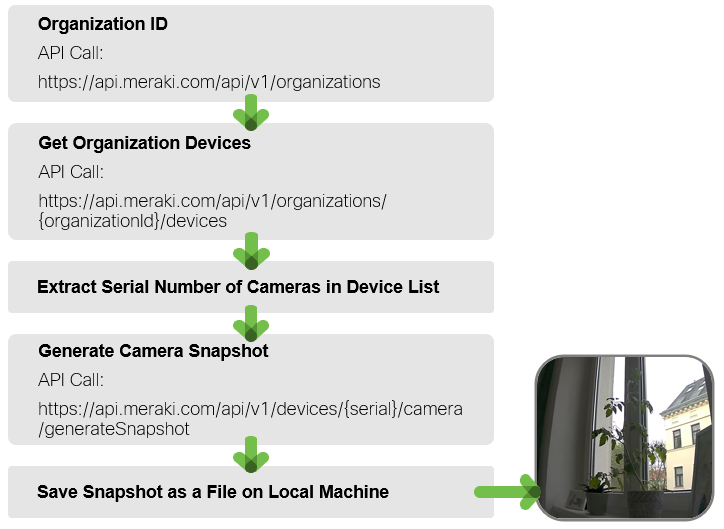

#### Cisco API & Developer Ressourcen:

* Meraki Developer: https://developer.cisco.com/meraki/api-v1/
* Cisco DevNet: https://developer.cisco.com/

## I. Libraries importieren

Für unseren Use-case brauchen wir einige vorgefertige Python Libraries die wir vorab importieren müssen.

In [3]:
# für API Calls und URL Formattierung
import requests
import urllib.request

# um Darstellen von Bilder
from PIL import Image
import imageio

# zum Formatieren von Daten und Zeitangaben
from datetime import datetime, timedelta, date
import time

## II. Variablen definieren

Als nächstes müsen wir unsere notwendigen Variablen definieren.

In unserem Fall brauchen wir:

1. **Meraki Dashboard API Token**: diesen gibt es in Ihrem [Meraki Dashboard](https://n201.meraki.com/login/dashbohttps://developer.webex.com/my-apps/neward_login)
2. **Webex Bot API Token**: diesen bekommen Sie nach der Erstellung Ihres Webex Bots via [Webex for Developers](https://developer.webex.com/my-apps/new). Für den Workshop bekommen Sie den Token von Ihrem Cisco Instructor.

In [1]:
meraki_api_key = "##-MERAKI-TOKEN-EINFÜGEN-##"
webex_api_key = "##-WEBEX-TOKEN-EINFÜGEN-##"

## III. API Calls ausführen

Die base URL der Meraki API ist: https://api.meraki.com/api/v1/

### 1. Organization ID

Mit unserem ersten API call müssen wir unsere Organization ID herausfinden.

👉 Die Dokumentation zu diesem Meraki API Call "Get Organization ID" gibt es [hier](https://developer.cisco.com/meraki/api-v1/#!get-organizations).

In [ ]:
# die API URL
url = "https://api.meraki.com/api/v1/organizations"

# der API Call Header
headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "X-Cisco-Meraki-API-Key": meraki_api_key
}

# der Payload, wird hier nicht benötigt
payload = None

# die tatsächliche Ausführung des API Calls
response = requests.request("GET", url, headers = headers, data = payload)

# das Ergebnis des Calls als JSON ausgeben
response.json()

Nun, dass wir das Ergebnis unseres Calls bekommen haben, müssen wir daraus unseres Organization ID extrahieren. Diese tun wir dann in eine separate Variable abspeichern.

In [ ]:
organizationId = response.json()[0]["id"]
print(organizationId)

### 2. Get Organization Devices

Im nächsten Schritt werden wir alle Devices in unserer Organization auflisten und daraufhin unsere Kameras rausfiltern.

👉 Die Dokumentation zu diesem Meraki API Call "Get Organization Devices" gibt es [hier](https://developer.cisco.com/meraki/api-v1/#!get-organization-devices).

In [ ]:
url = "https://api.meraki.com/api/v1/organizations/{organizationId}/devices".format(organizationId=organizationId)

payload = None

headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "X-Cisco-Meraki-API-Key": meraki_api_key
}

response = requests.request("GET", url, headers=headers, data = payload)

response.json()

### 3. Get Serial Number of Cameras

In diesem Schritt werden wir unsere Kameras aus der Liste unserer Organization Devices rausfiltern und dessen Seriennummern in eine separate Liste abspeichern.

In [ ]:
# leere Liste in der wir unsere Seriennummern abspeichern
serienNummern = []

# Loop über unsere Devices
for device in response.json():
    if "MV" in device["model"]:
      # if "GERÄTE-NAME" in device["name"]:
        serienNummern.append(device["serial"])

print(serienNummern)

### 4. Generate Camera Snapshot

Mit den Seriennummern unserere Kameras können wir unseren Snapshot API Call ausführen.

Für diesen API Call können wir entweder die Payload leer lassen und ein Snapshop vom jetzigen Zeitpunkt machen, oder wir können einen selbstdefinierten Zeitpunkt definieren.


👉 Die Dokumentation zu diesem Meraki API Call "Generate Device Camera Snapshot" gibt es [hier](https://developer.cisco.com/meraki/api-v1/#!generate-device-camera-snapshot).

In [ ]:
url = "https://api.meraki.com/api/v1/devices/{serial}/camera/generateSnapshot".format(serial=serienNummern[0])

payload = '''{}'''

# payload = '''{
#     "timestamp": "2021-04-20T05:01:54-07:00"
# }'''

headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "X-Cisco-Meraki-API-Key": meraki_api_key
}

response = requests.request("POST", url, headers=headers, data = payload)

response.json()

Das Ergebnis unseres Calls gibt uns einen Link zu unserem Snapshot und das Ablaufdatum unseres Snapshot Links. 

Den Link werden wir in einer Variable abspecheichern.

In [ ]:
imageURL = response.json()["url"]
print(imageURL)

Wir können unser Snapshop auch in Python darstellen:

In [ ]:
Image.open(requests.get(imageURL, stream=True).raw)

### 5. Snapshot lokal speichern

Das Snapshot wird gespeichert unter dem Namen `snapshot_heutigesDatum.jpg`.

In [16]:
imageName = "snapshot_" + date.today().strftime("%d%m%Y") + ".jpg"
urllib.request.urlretrieve(imageURL, imageName)   

('snapshot_24062021.jpg', <http.client.HTTPMessage at 0x7fd696cbb4d0>)

***

**Wir haben nun erfolgreich unser erstes Snapshot mit der Meraki Snapshot API ersellt!** 🎉

Jedoch, das Ziel unseres Workshops ist es nicht nur ein einziges Snapshot zu erstellen, sondern aus mehreren Snapshots eine Timelapse als GIF zu generieren.

### 6. Erstellung der Snapshopt Timelapse as GIF

Zur Erstellung unseres Timerlapses brauchen wir selbstverständlich mehrere Snapshot Dateien. Diese werden wir mit Python einlesen und dann zu einem GIF zusammenfügen.

In [17]:
# Liste der Dateinamen unserer Snapshots
snapshotNamen = ["snapshot_1.jpg", "04052021.jpg", "snapshot_24062021.jpg",]

# Erstellung des GIF
images = []
for filename in snapshotNamen:
    images.append(imageio.imread(filename))

# GIF lokal speichern
imageio.mimsave("mySnapshotTimelapse.gif", images)

### 7. Snapshots teilen via Webex

Zusätzlich zum lokalen Abspeichern unserer Snapshots können wir diese auch automatisiert via Webex teilen.

👉 Die Dokumentation zu diesem Webex API Call "Create a Message" gibt es [hier](https://developer.webex.com/docs/api/v1/messages/create-a-message).

In [ ]:
url = "https://api.ciscospark.com/v1/messages"

headers = {
    "content-type": "application/json; charset=utf-8",
    "authorization": "Bearer " + webex_api_key,
}

email = "##-EMAIL-EINFÜGEN-##"
msgtxt = "📸 Please view attached your Meraki Camera Snapshot! :)"


data = {"toPersonEmail": email,
        "markdown": msgtxt,
        "files": imageURL}

response = requests.post(url, json=data, headers=headers)

# Testen anhand der HTTP Status Codes ob das Senden der Nachricht erfolgreich war
if response.status_code == 200:
    print("Message successfully sent to:", email)
else:
    print("Oops, something went wrong! Satus code:", response.status_code)